# ECSE415 - Intro to Computer Vision
## Tutorial 5 - Feature Detection and Image Stitching in OpenCV

install opencv-contrib-python==3.3.0.10 if needed

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# HoG features

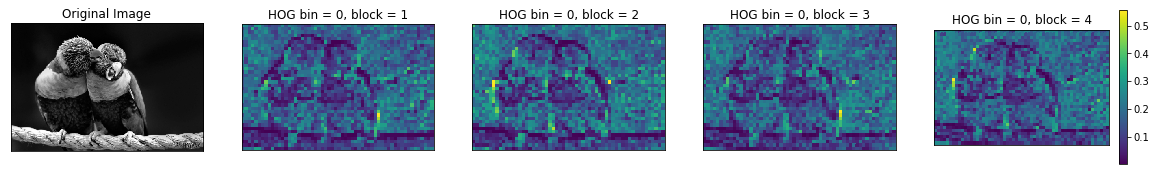

In [2]:
img = cv2.cvtColor(cv2.imread("bird.png"),
                   cv2.COLOR_BGR2GRAY)

cell_size = (8, 8)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins

# create HoG Object
# winSize is the size of the image cropped to multiple of the cell size
# all arguments should be given in terms of number of pixels
hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

# Compute HoG features
hog_feats = hog.compute(img) \
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[1], block_size[0], nbins) \
               .transpose((1, 0, 3, 2, 4))  # index blocks by rows first


# Preview
plt.figure(figsize = (20,100))
plt.subplot(151)
plt.imshow(img, cmap='gray')
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(152)
plt.pcolor(hog_feats[:, :, 0,0,0])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("HOG bin = 0, block = 1"), plt.xticks([]), plt.yticks([])

plt.subplot(153)
plt.pcolor(hog_feats[:, :, 0,1,0])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("HOG bin = 0, block = 2"), plt.xticks([]), plt.yticks([])

plt.subplot(154)
plt.pcolor(hog_feats[:, :, 1,0,0])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("HOG bin = 0, block = 3"), plt.xticks([]), plt.yticks([])

plt.subplot(155)
plt.pcolor(hog_feats[:, :, 1,1,0])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("HOG bin = 0, block = 4"), plt.xticks([]), plt.yticks([])
plt.colorbar(fraction=0.04)
plt.show()

## SIFT Features and Descriptors

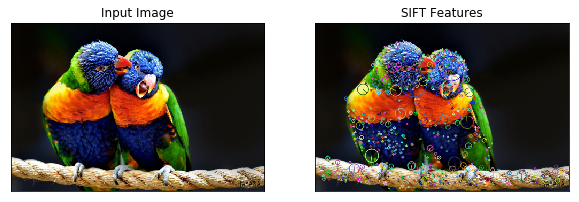

Num keypoints: 870


In [3]:
#########################
# SIFT FEATURE DETECTOR #
#########################

# load image 
img = cv2.imread("bird.png")
# copy image
img_disp = img.copy()
# convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features

# detect SIFT features, with no masks
keypoints = sift.detect(img, None)

# draw the keypoints
cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(img)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_disp)
plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()

# num of SIFT keypoints
print('Num keypoints: '+ str(len(keypoints)))

Num keypoints: 870
descriptors size: (870, 128)


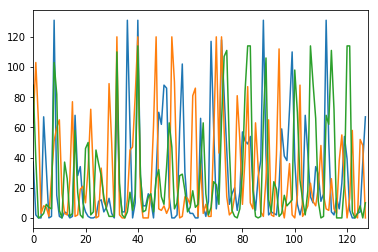

In [4]:
####################
# SIFT DESCRIPTORS #
####################

# load image 
img = cv2.imread("bird.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
keypoints = sift.detect(img, None)
print('Num keypoints: '+ str(len(keypoints)))

# compute SIFT descriptors
keypoints, descriptors = sift.compute(img, keypoints)

# Alternatively, we can use keypoints,descriptors = sift.detectAndCompute(img) to get both

# num of SIFT keypoints/descriptors
print('descriptors size: '+ str(descriptors.shape))

# plot a couple of 1x128 SIFT descriptors
num = 3
for i in range(num):
    # plot the 256x1 np array using matplotlib plot()
    plt.plot(descriptors[i])
    plt.xlim([0,128]) # set x-axis limit
plt.show()

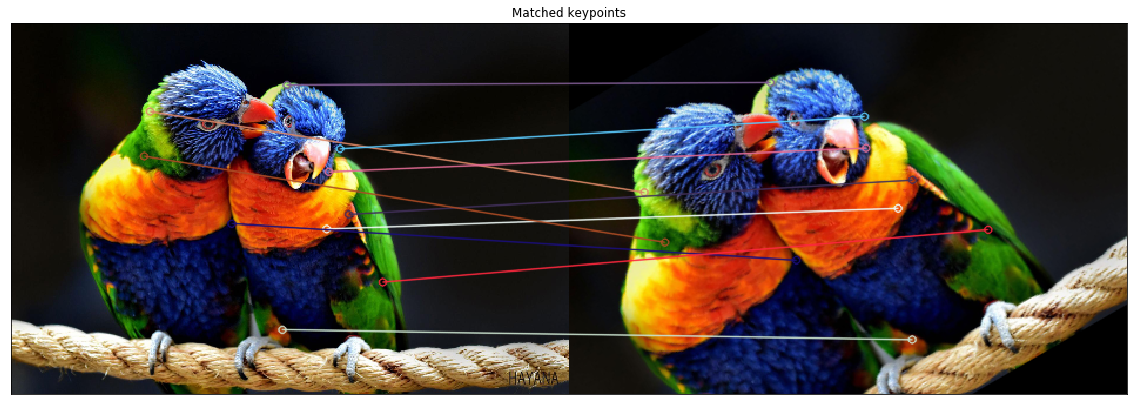

In [5]:
####################
# FEATURE MATCHING #
####################

# load the image 
img1 = cv2.imread("bird.png")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

height, width = img1.shape[0:2] # image size

# Create a rotated, scaled duplicate
# rotation marix around the center pixel, 30 degrees,scale of 1.2
M = cv2.getRotationMatrix2D((width/2,height/2),30,1.2)
# Apply the transformation matrix
img2 = cv2.warpAffine(img1,M,(width,height))

# Create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Compute the keypoints/descriptors
keypoints1,descriptors1 = sift.detectAndCompute(img1,None)
keypoints2,descriptors2 = sift.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(descriptors1,descriptors2) #query image, train image

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,keypoints1,img2,keypoints2, matches[:10], None, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(img3)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

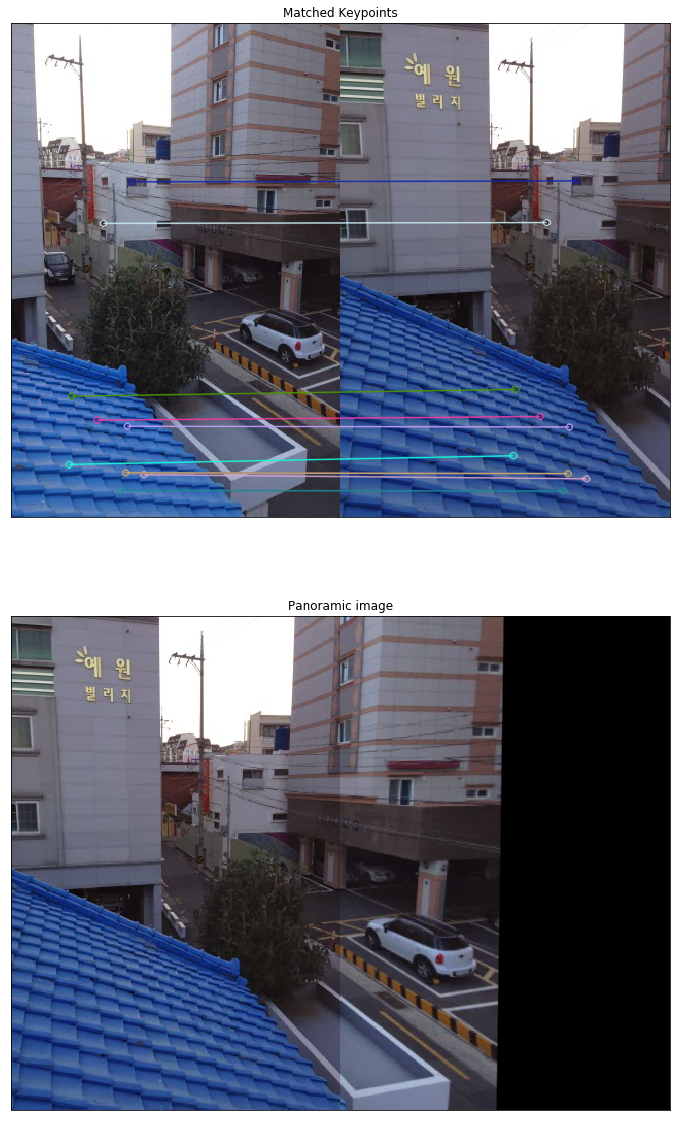

In [6]:
# Read images to stitch
imgl = cv2.imread('S1.jpg')
imgr = cv2.imread('S2.jpg')

imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)

# Compute keypoints and descriptors
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_l, descriptors_l = sift_obj.detectAndCompute(imgl, None)
keypoints_r, descriptors_r = sift_obj.detectAndCompute(imgr, None)

# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_r,descriptors_l) # query image, train image

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints 
imgmatch = cv2.drawMatches(imgr,keypoints_r,imgl,keypoints_l, matches[:10], None, flags=2)

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints_r[i].pt for (__, i) in GoodMatches])
mpl = np.float32([keypoints_l[i].pt for (i, __) in GoodMatches])

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(imgr, H, (imgr.shape[1]+imgl.shape[1],imgr.shape[0]))
wimg[:,:imgl.shape[1],:] = imgl

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(imgmatch)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
plt.subplot(212)
plt.imshow(wimg)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

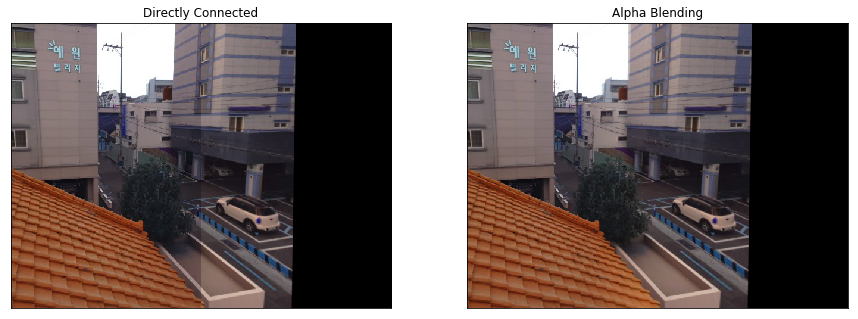

In [7]:
##################
# IMAGE BLENDING #
##################

# read images
A = cv2.warpPerspective(imgr, H, (imgr.shape[1]+imgl.shape[1],imgr.shape[0]))
B = np.zeros_like(A)
B[:,:imgl.shape[1],:] = imgl
A = A.astype('float')
B = B.astype('float')


# width and height of image
col, row = A.shape[0:2]

""" ALPHA BLENDING """
def Ramp(i_width, c_width, c_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (c_width-1)
    idx = round(c_index - (c_width / 2))  # left side starting index of alpha ramp
    for i in range(c_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 100  # alpha blending ramp size
alpha = Ramp(A.shape[1], ramp_size, 250, 0, 1).reshape(1, -1, 1)

# Now blend
I_blend = alpha * A + (1-alpha)*B
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(wimg, cv2.COLOR_RGB2BGR))
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(I_blend, cv2.COLOR_RGB2BGR))
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()